In [57]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml
from run_MMAML_04 import test as test_mmaml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from multimodallearner import get_task_encoder_input
from multimodallearner import LSTMDecoder, Lambda, MultimodalLearner
from metalearner import MetaLearner
from meta_base_models import LinearModel, Task

In [60]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }

lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

dataset_name = "BATTERY"
#dataset_name = "HR"

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )


n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

# fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
opt = optim.Adam(list(maml.parameters()) + list(multimodal_learner.parameters()), lr=meta_learning_rate)


task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))

In [61]:

experiment_id = "21_COMPARISON"
#experiment_id = "13_COMPARISON_2"
trial = 1


output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
save_model_file_2 = output_directory + experiment_id + "_model.pt"



multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)


multimodal_learner.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))
    

<All keys matched successfully>

In [62]:
task_embeddings_train = multimodal_learner.task_encoder.encoder(task_data_train.to(device)).cpu().detach().numpy()
mean_train = np.mean(task_embeddings_train, axis=0)
cov_train = np.cov(task_embeddings_train.T)
print(mean_train.shape)
print(cov_train.shape)

(120,)
(120, 120)


In [63]:
task_embeddings_test = multimodal_learner.task_encoder.encoder(task_data_test.to(device)).cpu().detach().numpy()
mean_test = np.mean(task_embeddings_test, axis=0)
cov_test = np.cov(task_embeddings_test.T)

In [64]:
task_embeddings_validation = multimodal_learner.task_encoder.encoder(task_data_validation.to(device)).cpu().detach().numpy()
mean_validation = np.mean(task_embeddings_validation, axis=0)
cov_validation = np.cov(task_embeddings_validation.T)

In [67]:
mean1 = mean_train.reshape(-1,1)
mean2 = mean_test.reshape(-1,1)
cov1 = cov_train
cov2 = cov_test

def bhatta_dist(mean1, mean2, cov1, cov2):
    u=(mean1-mean2)
    cov = (cov1+cov2)/2
    det1 = np.linalg.det(cov1)
    det2 = np.linalg.det(cov2)
    det = np.linalg.det(cov)
    out = (1/8)*np.dot(np.dot(u.T, np.linalg.inv(cov)),u) 
    print()
    print(out)
    return out

bhatta_dist(mean_train, mean_test, cov_train, cov_test)
bhatta_dist(mean_train, mean_validation, cov_train, cov_validation)
bhatta_dist(mean_validation, mean_test, cov_validation, cov_test)



0.2586903624112047

0.2924492887492107

0.024562105388822086


0.024562105388822086

In [38]:
task_data_validation.shape

torch.Size([5396, 50, 4])

In [39]:
task_data_test.shape

torch.Size([5488, 50, 4])

In [49]:
train_data.y

array([[0.08365078],
       [0.09991228],
       [0.10484059],
       ...,
       [0.24369114],
       [0.23299586],
       [0.21694014]])

In [50]:
validation_data.y

array([[0.15038585],
       [0.15212221],
       [0.14820383],
       ...,
       [0.1974869 ],
       [0.19845348],
       [0.2100476 ]])

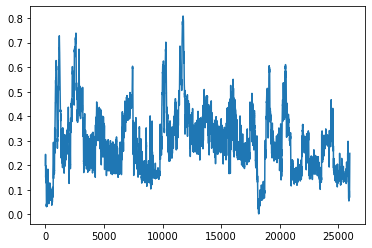

In [52]:
plt.plot(test_data.y)

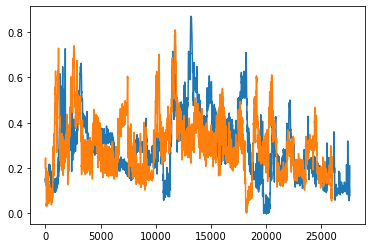

In [54]:
plt.plot(validation_data.y)
plt.plot(test_data.y)